[![Alt Right Community](/img/ALT_RIGHT.jpg)](https://www.jstor.org/stable/26984798?seq=1#metadata_info_tab_contents)

# The rise of far-right extremism speech between 2016 and 2020 
### Observed through a dataset of quotes from the press, highlighting the evolution of opinions and ideas that shape the past, present, and the future of our society.

$$ \\ $$

Project in Applied Data Analysis (CS-401)

*Team members: Camil Hamdane (SV), Clémentine lévy-Fidel (SV), Nathan Fiorellino (SV), Nathan Girard (SV)*



# **Section 1 : Wrangling**

## 1. Getting started

### 1.1 Installing and importing libraries



In [ ]:
!pip uninstall pandas -y

Found existing installation: pandas 1.1.5
Uninstalling pandas-1.1.5:
  Successfully uninstalled pandas-1.1.5


In [1]:
# Installations
!pip install pandas==1.0.5 
!pip install seaborn
!pip install tld
!pip install numpy
!pip install matplotlib
!pip install vaderSentiment

In [2]:
# Imports
import os
import ast
import requests
import re
import string

import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from urllib.parse import urlparse
from string import punctuation
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from html.parser import HTMLParser

In [3]:
# Google import
from google.colab import drive
from google.colab import files

### 1.2 Mounting drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Data Path 
input_path = '/content/drive/MyDrive/Quotebank/'
data_storage_path = '/content/drive/Shareddrives/Ada-The data collectivists/data/'

primer_input = "quotes-"
tail_input = ".json.bz2"

primer_output = "df_FF"
tail_output = ".csv"

years = ["2016", "2017", "2018", "2019", "2020"]

## 2. Preprocessing



### 2.1 Extraction of the data

#### a. Data Exploration


We first take a quick look at the data so that we can confirm that we read it correctly and that we get an  idea of what it looks like so we can better decide how we will preprocess and particularly what kind of filters are relevant.

In [ ]:
path_to_file = input_path + primer_input + years[2] + tail_input

Columns
Index(['quoteID', 'quotation', 'speaker', 'qids', 'date', 'numOccurrences',
       'probas', 'urls', 'phase'],
      dtype='object')
Colum 1 and 2
             quoteID                                          quotation
0  2018-06-30-000005  ... a minimum of 5.25 trillion (plastic) parti...
1  2018-12-06-000021  ... a race to see who could sail around the wo...
2  2018-04-25-000107  ... a tyrant whose chin might be lumps of grap...
3  2018-06-28-000032  [ Alberto ] attempted at this time to resolve ...
4  2018-09-15-000010  ... Among the many observations I have receive...
Colum 3 and 4
          speaker                                               qids
0  Marcus Eriksen                                        [Q55997400]
1     James Marsh  [Q2720543, Q41757028, Q56510432, Q6138937, Q99...
2            None                                                 []
3            None                                                 []
4            None                                     

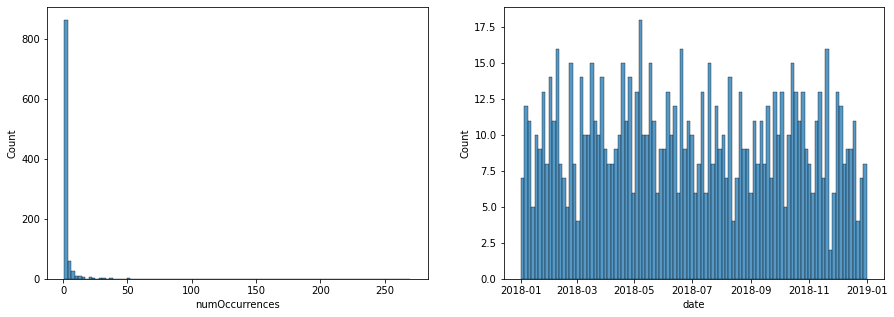

In [ ]:
df_reader = pd.read_json(path_to_file,lines = True, compression = 'bz2', chunksize = 1_000)
for chunk in df_reader:
  # We will only process one chunk here (The reason why we don't just )
  print("Columns")
  print(chunk.columns)
  print("Colum 1 and 2")
  print(chunk.iloc[0:5,0:2])
  print("Colum 3 and 4")
  print(chunk.iloc[0:5,2:4])
  print("Colum 5 and 6")
  print(chunk.iloc[0:5,4:6])
  print("Colum 7 and 8")
  print(chunk.iloc[0:5,6:8])
  print("Colum 9")
  print(chunk.iloc[0:5,8])
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  sns.histplot(ax = axes[0], data = chunk['numOccurrences'], bins = 100)
  sns.histplot(ax = axes[1], data = chunk['date'], bins = 100)
  break

In this section, we extract the data and preprocess it, such that we can better conduct our analysis. The Data exploration brought us to choose the following filtering steps:

- Remove quotes with low numOccurences, less than **10**,
- Remove quotes that have more than **1** speaker,
- Filter for samples with only **1** QID,
- Keep quotes whose probability is higher than **0.6**
- Remove **"phase"** feature of the dataframe
- Remove news outlets relaying less than a certain number of quotes, as they do not contribute to reflecting global trends.

Because of the huge size of the data and the limited capacity of the RAM provided by Google, we decided to process the data **per year**. In addition, chunks of data (per year) are processed sequentially to avoid exceed storage capacity. This preprocessing pipeline filters most of the data, such that **approximately 4%** of the initial data remains at the end. We obtain therefore clean and usable data for further analysis, stored in files named *"processed_quotes-20XX.csv"*, for each year. 

In [ ]:
# Constants
min_occurence = 10
acceptable_QID_amount = 1
min_probability = 0.6
remove_columns = ["phase"]

In [ ]:
# Definition of helper functions

def clean_chunk(chunk):
    """ 
        Cleans dataset chunk by removing unattributed quotes (quotes whose most probable speaker is unknown) or quotes whose speaker name is associated with more 
        than 1 alias removes 'probas' column and keep only quotes whose speaker probability is greater than 0.6 removes 'phase' column.
    """          
    chunk_clean = chunk.copy()
    
    # Remove Samples with low numOccurences
    chunk_clean = chunk_clean[chunk_clean['numOccurrences'] > min_occurence]

    # Filtering for samples containing exactly one QIDs
    chunk_clean = chunk_clean.loc[chunk_clean[chunk_clean['qids'].map(len) == 1].index]
    chunk_clean['qids'] = chunk_clean['qids'].apply(lambda qids: qids[0])
    
    # Remove samples with more than 1 speaker 
    if chunk_clean['probas'].dtype != 'float64': # In case the 'probas' column has already been pre-processed
        chunk_clean['probas'] = chunk_clean['probas'].apply(lambda probas: float(probas[0][1]))
    
    # Remove Samples with low probability
    chunk_clean = chunk_clean[chunk_clean['probas'] > min_probability]
    
    # Removing phase feature
    if 'phase' in chunk_clean: # In case the 'phase' column has already been pre-processed
        chunk_clean = chunk_clean.drop('phase', axis = 1)
      
    return chunk_clean

In [ ]:
def describe_chunk(size, i, add_string):
    """
        Print the size of the chunk processed and its number. 
    """
    
    print(f'{add_string} processing of chunk n°{i+1} with {size} rows')
    print("")

In [ ]:
def filter_year(path_to_file, chunksize):
  df_reader = pd.read_json(path_to_file, lines = True, compression = 'bz2', chunksize = chunksize)

  year_df = pd.DataFrame()
  i = 0
  describe_chunk(chunksize, i, "Begining")
  for chunk in df_reader:
    chunk = clean_chunk(chunk)
    year_df = year_df.append(chunk)
    describe_chunk(len(chunk), i, "Ending")
    i = i + 1
    describe_chunk(chunksize, i, "Begining")
  return year_df

In [ ]:
chunksize = 10000

In [ ]:
def filter_news_outlets(df):
  """ 
    Removing irrelevant news outlets: news outlets that haven't published more than 10 quotes
  """
  # Convert string-formatted list into list
  #chunk_clean['urls'] = chunk_clean['urls'].map(lambda x: ast.literal_eval(x))
  # Expand each quote into several rows, one for each URL
  df_expanded = df.explode('urls')
  # Replace each URL by its domain only
  df_expanded['urls'] = df_expanded['urls'].map(lambda x: urlparse(x).netloc)
  # Count number of domains per quote
  domain_count = df_expanded[['quoteID', 'urls']].groupby(['urls']).count()
  # Create list of domains occuring publishing less than 10 quotes
  single_domain = domain_count[domain_count['quoteID']<10].index.to_list()
  # Get quoteID of quotes quoted by one of these domains
  quoteID_single_domain = set(df_expanded[df_expanded['urls'].isin(single_domain)]['quoteID'])
  # Drop quotes with obtained quoteID from chunk
  return df.drop(df[df['quoteID'].isin(quoteID_single_domain)].index)

In [ ]:
def handle_year(i):
  path_to_file = input_path + primer_input + years[i] + tail_input
  year_df = filter_year(path_to_file,chunksize)
  year_df = filter_news_outlets(year_df)
  return year_df

In [ ]:
df_ff_2016 = handle_year(0) #2016

In [ ]:
path_to_output = data_storage_path + primer_output + '/' + primer_output + years[0] + tail_output
df_ff_2016.to_csv(path_to_output, encoding = 'utf-8')

In [ ]:
df_ff_2017 = handle_year(1)#2017

In [ ]:
path_to_output = data_storage_path + primer_output + '/' + primer_output + years[1] + tail_output
df_ff_2017.to_csv(path_to_output, encoding = 'utf-8')

In [ ]:
df_ff_2018 = handle_year(2) #2018

In [ ]:
path_to_output = data_storage_path + primer_output + '/' + primer_output + years[2] + tail_output
df_ff_2018.to_csv(path_to_output, encoding = 'utf-8')

In [ ]:
handle_year(3) #2019

In [ ]:
path_to_output = data_storage_path + primer_output + '/' + primer_output + years[3] + tail_output
df_ff_2019.to_csv(path_to_output, encoding = 'utf-8')

In [ ]:
handle_year(4) #2020

In [ ]:
path_to_output = data_storage_path + primer_output + '/' + primer_output + years[4] + tail_output
df_ff_2020.to_csv(path_to_output, encoding = 'utf-8')

# 3. Selection with Hatebase

In [6]:
#Import dataframes
path_to_folder = 'drive/Shareddrives/Ada-The data collectivists/data/df_FF/'
#df_2016 = pd.read_csv(path + file_name)
files = [f for f in os.listdir(path_to_folder) if os.path.isfile(
        os.path.join(path_to_folder, f)) and f[-3:] == 'csv']
files

['df_FF2019.csv',
 'df_FF2016.csv',
 'df_FF2020.csv',
 'df_FF2017.csv',
 'df_FF2018.csv']

In [7]:
hate_frame = 'HateBase/hateframe.csv'

In [8]:
hate_path = data_storage_path + hate_frame
hateframe = pd.read_csv(hate_path)
hateframe['Term'] = hateframe['Term'].str.lower()
hateset = set(hateframe['Term'])
hateset = [' {} '.format(x).lower() for x in hateset]

In [9]:
#One hot vector with hate "domains"
one_hot = list(hateframe.columns)[2:]


def extract_hate(df_, hateframe):

  
  out = df_.copy()
  for col in one_hot: out[col] = 0


  out['quotation'] = out['quotation'].str.lower()
  out['quotation'] = out['quotation'].apply(lambda x: f' {x} ',)
  out["quotation"] = out['quotation'].str.replace('[^\w\s]','')

  
  out = out[out['quotation'].str.contains('|'.join(hateset))]


  for index, row in out.iterrows():
    match = re.search('|'.join(hateset), str(row['quotation']))
    if match is not None:
      
      hateword = match[0].strip()
      out.loc[index, one_hot] = hateframe.query('Term == @hateword').loc[:, one_hot].squeeze() 

  return out

  
def build_hate_frame(path, files, hateframe):
  
  out = pd.DataFrame()

  for file_ in files:
    df_temp = extract_hate(pd.read_csv(path + file_), hateframe)
    out = out.append(df_temp)

  return out


df = build_hate_frame(path_to_folder, files, hateframe)

In [10]:
hateful_filename = 'df_hateful.csv'
df.to_csv(data_storage_path + hateful_filename, encoding = 'utf-8')

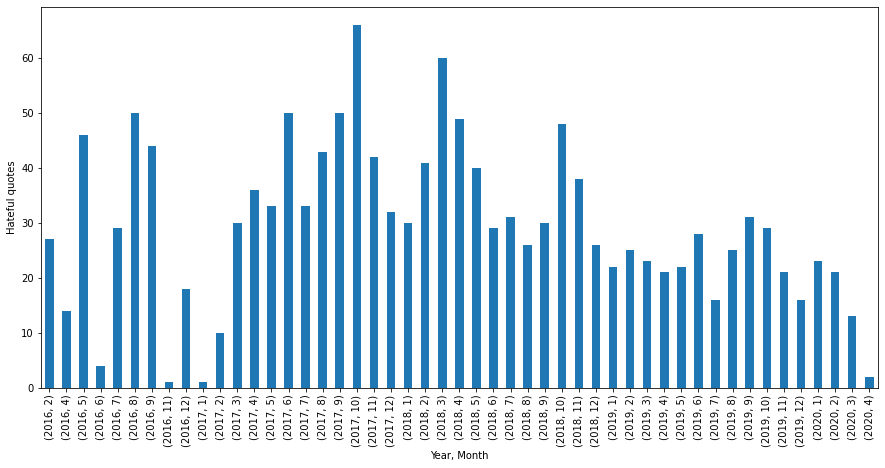

In [11]:
df["date"] = (df["date"].astype("datetime64"))
df["year"] = df['year'] = pd.DatetimeIndex(df['date']).year
df["month"] = df['month'] = pd.DatetimeIndex(df['date']).month

month_groups = df.groupby([df['year'],df['month']]
                          ).size()

month_groups.plot(kind='bar',figsize=(15,7),legend=None)
plt.xlabel("Year, Month")
plt.ylabel("Hateful quotes")
plt.show()

We notice that with this first filtering, the median is now at 23 occurences per quote, which tends to prove more the veracity of the quote than the preivous median of 1.

#### Hate topics presence

But what are the hate quotes directed towards? We can answer that by using a very useful feature: the 'is_about' columns, that collect the topic associated with the word that made a quote be detected by the hateframe extraction. Let's have a look at what the dataframe looks like, we'll find the different topics in its columns:

In [12]:
df.head(2)

,Unnamed: 0,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,is_about_nationality,is_about_ethnicity,is_about_religion,is_about_gender,is_about_sexual_orientation,is_about_disability,is_about_class,number_of_sightings,year,month
384,21207,2019-09-06-048692,it celebrates the queer community within fash...,Suhaly Bautista-Carolina,Q43380935,2019-09-06 00:00:00,43,0.8508,['http://www.dailyherald.com/article/20190906/...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,940.0,2019,9
3881,218949,2019-04-29-075175,the lamest leastinteresting newfie joke ive h...,Mark Critch,Q6767200,2019-04-29 07:35:00,40,0.8024,['http://timescolonist.com/the-simpsons-takes-...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,2019,4


By summing all the one hot values over the 7 hate topics (nationality, ethnicity, religion, gender, sexual orientation, disability, and social class), we have the following patterns:

In [13]:
topics = df[['is_about_nationality', 'is_about_ethnicity', 'is_about_religion',	'is_about_gender', 'is_about_sexual_orientation', 'is_about_disability', 'is_about_class']].sum()
topics

is_about_nationality           360.0
is_about_ethnicity             625.0
is_about_religion               89.0
is_about_gender                411.0
is_about_sexual_orientation    149.0
is_about_disability             65.0
is_about_class                 115.0
dtype: float64

We notice that some topics receive more hateful quotes than others, namely ethnicity (which suggest racist speech) and gender (which suggests sexism).

## 4. Populating speaker information

We are now interested about knowing more about the speakers at the origin of hateful quotes. Information about the speakers can be found via their Wikidata QID. Wikidata are stored as a parquet file, containing attributes like the different aliases for a speaker, their date of birth, nationality, gender, ethnic group, US congress identifier, occupation, party, academic degree, candidacy, or religion. From intuition, we decide to discard  attributes like US congress idenitfiers, candidacy or academic degree, as they only concern a small fraction of the speakers population. Whether about these discarded attributes or the remaining ones, a problem remains: the fact that not all attributes are registered in the database, even if they exist, so we must keep careful when anlyzing the proportions of certain categories. But let's dive into the metadata!


First, we need to load the parquet file, format it a bit so as to be readble and finally merge it with the quotes dataframe.

In [14]:
# Load metadata about speakers
parquet_path = 'drive/Shareddrives/Ada-The data collectivists/datasets/speaker_attributes.parquet'


def extract_metadata(parquet_path):
  """
    Processes speakers attributes from Wikidata parquet path, selects specific attributes and returns handable
  """
  df_metadata = pd.read_parquet(parquet_path)
  columns_of_interest = ['id', 'label', 'ethnic_group', 'religion', 'gender', 'nationality', 'date_of_birth' , 'occupation' , 'party']
  dfm = df_metadata[columns_of_interest]
  crucial_columns = ['id', 'label', 'date_of_birth']

  for column in dfm.columns:
    if column in crucial_columns:
      # delete rows with empty label, ID or date of birth (as we will later only need quotes from contemporary, e.g. not George Washington)
      dfm = dfm[~dfm[column].map(lambda x: x is None)]
    else:
      # select non-None rows
      none_index = dfm[column].map(lambda x: x is None)
      # When several attributes in one column, only keep the first
      dfm.loc[~none_index, column] = dfm.loc[~none_index, column].map(lambda x: x[0])

    if column == 'date_of_birth':
      # Extract birth year from date_of_birth column
      dfm[column] = dfm[column].map(lambda x: x[0].split('-', 1)[0][1:])
      # Delete rows for unknown birthdates
      dfm = dfm.drop(dfm[dfm[column]==''].index)
      # Convert birth year to float
      dfm[column] = dfm[column].astype('float64')

  return dfm

dfm = extract_metadata(parquet_path)
dfm.head(5)

,id,label,ethnic_group,religion,gender,nationality,date_of_birth,occupation,party
0,Q23,George Washington,None,Q682443,Q6581097,Q161885,1732.0,Q82955,Q327591
1,Q42,Douglas Adams,Q7994501,None,Q6581097,Q145,1952.0,Q214917,None
2,Q1868,Paul Otlet,None,None,Q6581097,Q31,1868.0,Q36180,None
3,Q207,George W. Bush,None,Q329646,Q6581097,Q30,1946.0,Q82955,Q29468
4,Q297,Diego Velázquez,None,None,Q6581097,Q29,1599.0,Q1028181,None


Before anything else, adding the metadata allows us to get rid of non plausible quotes from the quotes dataframe, i.e. quotes related to speakers born before 1910 (we asssume that there can still be living centenarians).


In [15]:
# Some little helper functions
def get_hate_speakers(df_quotes, df_metadata):
  """
    Returns dataframe extract from the metdata
  """
  hate_speakers = df_metadata[df_metadata['id'].isin(df_quotes.qids.unique())]
  return hate_speakers

def clean_plausible_quotes(df_quotes, df_metadata):
  """
    Deletes non plausible quotes, i.e. quotes from speakers that were born before 1910 or speakers whose date of birth is not known
  """
  hate_speakers = get_hate_speakers(df_quotes, df_metadata)
  non_plausible = hate_speakers.query('date_of_birth < 1910').id
  return df_quotes.drop(df_quotes[df_quotes['qids'].isin(non_plausible)].index)


df = clean_plausible_quotes(df, dfm)

Now we can look at the attributes distributions. The most delicate ones are gender, nationality, ethnic group, religion and party. Let's verify how much (or how not much) represented they are.



In [ ]:
class WikidataHTMLParser(HTMLParser):
    def handle_starttag(self, tag, attrs):
        if(tag == 'meta'):
          property_tuples = [item for item in attrs if item[0] == 'property']
          if len(property_tuples) == 1 and (property_tuples[0][1] == 'og:title'):
            self.data = attrs[1][1]

def translateQid(qid):
  response = requests.get(url='https://www.wikidata.org/wiki/'+ qid)
  parser = WikidataHTMLParser()
  parser.feed(response.text)
  return parser.data

def evaluate_column_value(column_name):
  defined_value = hate_speakers[~hate_speakers[column_name].isnull()]
  instance_list = (defined_value.drop_duplicates(subset = [column_name]))[column_name].tolist()
  instance_amounts = defined_value.pivot_table(columns=[column_name], aggfunc='size').tolist()
  instance_list =  [translateQid(qid) for qid in instance_list]
  zip_iterator = zip(instance_list, instance_amounts)
  repartition = dict(zip_iterator)
  print(repartition)
  return pd.DataFrame(list(repartition.items()), index = repartition.keys())

hate_speakers = get_hate_speakers(df, dfm)

column_names = ['ethnic_group', 'religion', 'gender', 'nationality','party']
for name in column_names:
  print(name)
  column_repartition = evaluate_column_value(name)

ethnic_group
{'Gujarati people': 2, 'African Americans': 2, 'Irish people': 1, 'Jews': 1, 'Turkish American': 1, 'Edo people': 1, 'Irish Americans': 1, 'Scottish American': 1, 'Britons': 1, 'German Brazilians': 1, 'Polish American': 1, 'White British': 1, 'Hausa people': 1, 'Indigenous Australians': 2, 'Maltese American': 1, 'Italian Argentines': 1, 'American Jews': 1, 'Sindhis': 1, 'mixed race people': 1, 'Yoruba people': 4, 'Thai people': 1, 'Copts': 1, 'Italian American': 2, 'Croats': 1, 'white Americans': 1, 'Igbo people': 1, 'Armenian American': 1, 'South Asian American': 2, 'Colombian American': 1, 'Sikh': 1, 'Serbs': 1, 'Slovenes': 1, 'Hungarians': 2, 'Cuban American': 82, 'Navajo': 1, 'French': 1, 'Persians': 3, 'Japanese people': 7, 'English people': 2, 'Visayans': 1, 'Chinese Americans': 2}
religion
{'Hinduism': 1, 'Baptists': 1, 'Catholicism': 1, 'Lutheranism': 1, 'Judaism': 1, 'Islam': 3, 'Christianity': 2, 'atheism': 1, 'agnosticism': 1, 'Catholic Church': 3, 'Methodism': 

To summarize this, let's see how many different values there are, and how many defined values there are for each:

In [ ]:
column_names = ['ethnic_group', 'religion', 'gender', 'nationality','party']
for name in column_names:
  defined_value = hate_speakers[~hate_speakers[name].isnull()]
  print(f"{name}: attribute defined for {len(defined_value)} | {len(defined_value[name].unique())} different values")

ethnic_group: attribute defined for 141 | 41 different values
religion: attribute defined for 171 | 39 different values
gender: attribute defined for 933 | 8 different values
nationality: attribute defined for 879 | 53 different values
party: attribute defined for 240 | 57 different values


In [ ]:
print(f"As a reminder, we are now dealing with {len(df)} quotes ...")

As a reminder, we are now dealing with 1439 quotes ...


So we observe that, as we hypothesized, some attributes are not very relevant as they are not representated for the majority of the speakers. This concerns especially ethnic group, religion and political party, so we will not try to draw conclusions from these attributes.


But it's not the only comment we can make from these observations. A reason why it would be hard to cluster the quotes to simple, englobing categories of speakers, is because there are several dozens of different values for each category, which makes that the speakers are very diverse! Let's have another look:

In [ ]:
ethnic_groups = evaluate_column_value('ethnic_group')
ethnic_groups.sort_values(by = 1, ascending = False)[1]

{'Gujarati people': 2, 'African Americans': 2, 'Irish people': 1, 'Jews': 1, 'Turkish American': 1, 'Edo people': 1, 'Irish Americans': 1, 'Scottish American': 1, 'Britons': 1, 'German Brazilians': 1, 'Polish American': 1, 'White British': 1, 'Hausa people': 1, 'Indigenous Australians': 2, 'Maltese American': 1, 'Italian Argentines': 1, 'American Jews': 1, 'Sindhis': 1, 'mixed race people': 1, 'Yoruba people': 4, 'Thai people': 1, 'Copts': 1, 'Italian American': 2, 'Croats': 1, 'white Americans': 1, 'Igbo people': 1, 'Armenian American': 1, 'South Asian American': 2, 'Colombian American': 1, 'Sikh': 1, 'Serbs': 1, 'Slovenes': 1, 'Hungarians': 2, 'Cuban American': 82, 'Navajo': 1, 'French': 1, 'Persians': 3, 'Japanese people': 7, 'English people': 2, 'Visayans': 1, 'Chinese Americans': 2}


Cuban American            82
Japanese people            7
Yoruba people              4
Persians                   3
Gujarati people            2
Indigenous Australians     2
English people             2
Hungarians                 2
South Asian American       2
Italian American           2
African Americans          2
Chinese Americans          2
Hausa people               1
Scottish American          1
Visayans                   1
Irish people               1
Jews                       1
Turkish American           1
French                     1
Navajo                     1
Edo people                 1
Irish Americans            1
Slovenes                   1
Serbs                      1
Sikh                       1
Colombian American         1
Armenian American          1
White British              1
Igbo people                1
white Americans            1
Croats                     1
Britons                    1
Copts                      1
German Brazilians          1
Polish America

Looking more closely at the values, we notice that, for example, the most present ethnic groups are Cuban Americans, which is surprising and would most probably stem from previous filtering. The same goes even for the attributes we thought would be more useful, like gender and nationality: the most present values are groups that are usually minorities. It is striking in the case of gender: speakers labeled as male are 5, speakers labeled as women are actually one, but there are 234 speakers labeled as transgender male and 684 speakers labeled as genderqueer. This first rises the question: are minorities more hateful? A question to which we could bring the following solutions: either our hate speech filters is not specific enough, or minorities aren't hateful per se but would tend to use more offensive language, and thus be detected as hateful speakers. One reason often studied is the reappropriation of insults, for example in the context of [LGBTQI+ movements](https://journals.sagepub.com/doi/full/10.1177/0261927X20967394?casa_token=QToOY04TNn0AAAAA%3AFKht680oUFkjlaT2bx-gjGYeZaje78x_Yq31q4yCBGLVpj9grsuT0dCmyo3ykZgtE3lFUyOKq0Aq9ik) or in the language used in rap music. More genereally, it opens to the fact that not all offensive speech is intended as directly hateful, [a problem often encountered with automated speech detection](https://arxiv.org/abs/1703.04009).

# **Section 2 : Data Analysis**

## 1. Hypotheses

## Hate speech is on the rise since 2016

### 1.1 Simple evolution (occurence per year)

In [41]:
input_path = "/content/drive/Shareddrives/Ada-The data collectivists/data/"
tail_output = ".csv"
FF = "df_FF/df_FF"
SF = "df_SF/df_SF"
preprocessed_path = input_path + FF 
preprocessed_hate_path = input_path + SF

years = ["2016", "2017", "2018", "2019", "2020"]

In [42]:
def add_date_details(df):
  """
      Add date details about year, month, and year-month in the dataframe.
  """

  df['year'] = pd.DatetimeIndex(df['date']).year
  df['month'] = pd.DatetimeIndex(df['date']).month
  df['month_year'] = pd.to_datetime(df['date']).dt.to_period('M')

  return df

def hate_proportion_per_year():
  """
    Return statistics of hate quotes per year in a dataframe.
  """
  n_total = []
  n_occ_total = []
  n_max_occ = []
  mean_occ = []
  proportion = []

  month_year = df_filter_hate["month_year"].unique()

  for year in years:
    first_filter_tmp = pd.read_csv(preprocessed_path + year + tail_output, encoding = "utf-8")
    filter_hate_tmp = df_filter_hate.query("year == @year")
    # filter_hate_tmp = pd.read_csv(preprocessed_hate_path + year + tail_output, encoding = "utf-8")

    first_filter_tmp['month'] = pd.DatetimeIndex(first_filter_tmp['date']).month

    months = filter_hate_tmp["month"].unique()

    for month in months:
      hate_tmp = filter_hate_tmp.query("month == @month")
      filter_tmp = first_filter_tmp.query("month == @month")

      n_total.append(hate_tmp["quotation"].nunique())

      n_occ_total.append(hate_tmp["numOccurrences"].agg("sum"))

      n_max_occ.append(hate_tmp["numOccurrences"].agg("max"))

      mean_occ.append(hate_tmp["numOccurrences"].agg("mean"))

      if len(filter_tmp) != 0:
        proportion.append(len(hate_tmp) / len(filter_tmp))
      else:
        proportion.append(None)

  df_occ = pd.DataFrame({"number of quotes":n_total, "Total number of occurences": n_occ_total,
                        "Maximum number of relay": n_max_occ, "Proportion of hate": proportion,
                        "Mean number of occurrences": mean_occ}, index = month_year).fillna(0)

  return df_occ

def plot_occurrence_stats(df):
  """
      Plot statistics resulting from the method hate_proportion_per_year.
  """

  n_col = len(df.columns)
  columns = df.columns.values
  fig, axs = plt.subplots(n_col//2, n_col//2 + 1, figsize=(20, 10))
  axs = axs.ravel()

  for index, name in enumerate(columns):
    sns.barplot(ax=axs[index], x=df.index, y = df[name].values, palette = "Blues_d")
    axs[index].set_title(name)

In [43]:
df_filter_hate = pd.read_csv(preprocessed_hate_path + tail_output, encoding = "utf-8")
df_filter_hate = add_date_details(df_filter_hate) 
df_filter_hate.head()

,Unnamed: 0,Unnamed: 0.1,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,is_about_nationality,is_about_ethnicity,is_about_religion,is_about_gender,is_about_sexual_orientation,is_about_disability,is_about_class,number_of_sightings,year,month,month_year
0,384,21207,2019-09-06-048692,it celebrates the queer community within fash...,Suhaly Bautista-Carolina,Q43380935,2019-09-06 00:00:00,43,0.8508,['http://www.dailyherald.com/article/20190906/...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,940.0,2019,9,2019-09
1,3881,218949,2019-04-29-075175,the lamest leastinteresting newfie joke ive h...,Mark Critch,Q6767200,2019-04-29 07:35:00,40,0.8024,['http://timescolonist.com/the-simpsons-takes-...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,2019,4,2019-04
2,4559,259043,2019-03-20-074667,queer and ready to party,Miley Cyrus,Q4235,2019-03-20 07:07:00,22,0.7774,['https://www.castanet.net/news/Entertainment/...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,940.0,2019,3,2019-03
3,4762,270618,2019-06-23-043963,the studio was once a confederate army base w...,Tyler Perry,Q686301,2019-06-23 00:00:00,57,0.6728,['http://dailyherald.com/news/20190623/bet-awa...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,85.0,2019,6,2019-06
4,7414,421460,2019-06-28-088404,try to do it and i will do it son of a bitch,Rodrigo Duterte,Q457786,2019-06-28 00:00:00,14,0.8400,['https://ewn.co.za/2019/06/28/impeach-me-i-ll...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1554.0,2019,6,2019-06


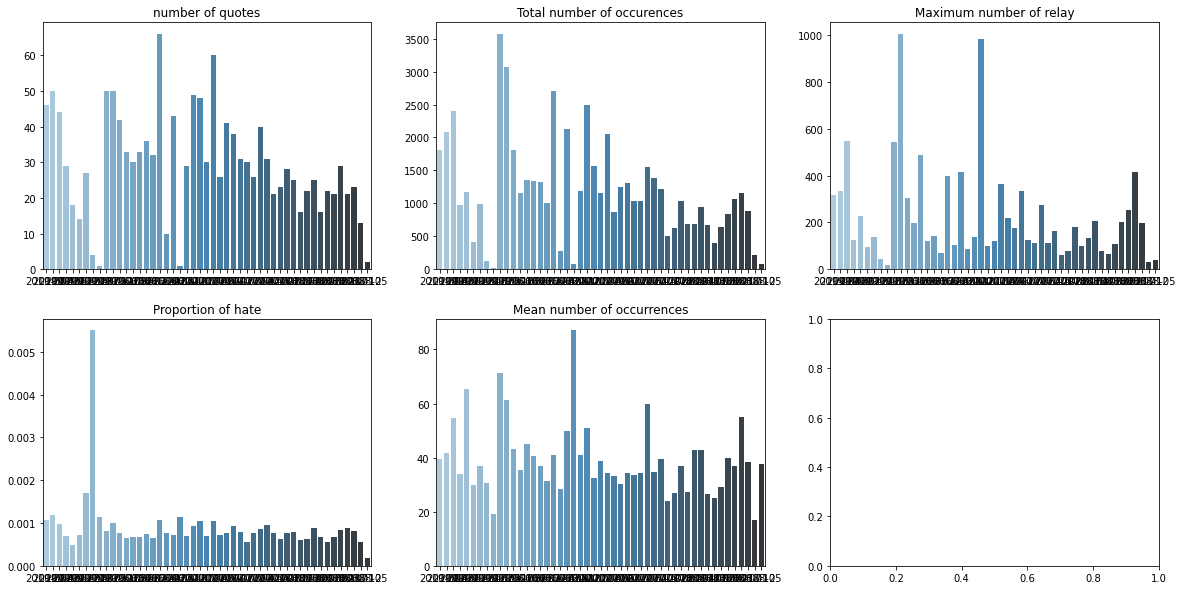

In [44]:
df_occ = hate_proportion_per_year()
df_occ.head()
plot_occurrence_stats(df_occ)

### 1.2 Media outlet evolution

In [46]:
def extract_domain(df):
  # Convert string-formatted list into list
  df['urls'] = df['urls'].map(lambda x: ast.literal_eval(x))
  # Expand each quote into several rows, one for each URL
  df_expanded = df.explode('urls')
  # Replace each URL by its domain only
  df_expanded['urls'] = df_expanded['urls'].map(lambda x: urlparse(x).netloc)

  return df_expanded

def occurence_per_outlet_and_year(n_plotted = 10, plot = False):
  """
      Return statistics on the occurrence of hate quotes per media outlet.
  """

  occ_media = pd.DataFrame()
  occ_media_total = pd.DataFrame()

  for year in years:
    first_filter_tmp = pd.read_csv(preprocessed_path + year + tail_output, encoding = "utf-8")
    filter_hate_tmp = df_filter_hate.query("year == @year") # Before having hate data in .csv
    # filter_hate_tmp = pd.read_csv(preprocessed_hate_path + year + tail_output, encoding = "utf-8")

    # renaming column urls to indicate year of publication
    first_filter_tmp = extract_domain(first_filter_tmp)
    filter_hate_tmp = extract_domain(filter_hate_tmp)

    first_filter_tmp.explode('urls').rename(columns={"urls" : "urls"+year}, inplace = True)
    filter_hate_tmp.explode('urls').rename(columns={"urls" : "urls"+year}, inplace = True)
    
    occ_media.append(filter_hate_tmp["urls"+year].value_counts()) 
    occ_media_total.append(first_filter_tmp["urls"+year].value_counts())

  if plot:
    plot_occ_media(occ_media.fillna(0), occ_media_total.fillna(0), n_plotted)

  return occ_media.fillna(0), occ_media_total.fillna(0)


def plot_occ_media(occ_media, occ_media_total, n_plotted = 10):
  """
      Relayed number of hate (versus total) quotes per media outlet (plot only
      for outlets that already existed in 2016).
  """
  
  first_filter_tmp = pd.read_csv(preprocessed_path + years[0] + tail_output, encoding = "utf-8")

  # Retrieve unique outlet names
  outlet_names = first_filter_tmp["urls"].unique()

  # Sampling "n_plotted" outlet names
  outlet_names_to_plot = np.random.choice(outlet_names, size = n_plotted)

  fig, axs = plt.subplots(n_plotted//2, n_plotted//2 + 1, figsize=(10, 10))
  axs = axs.ravel()

  for index, name in enumerate(outlet_names_to_plot):
    sns.histplot(occ_media.loc[name], x = years, ax = axs[index], color = "")
    sns.histplot(occ_media_total.loc[name], x = years, ax = axs[index], color = "")

    axs[index].legend["Hate quotes", "All quotes"]
    axs[index].set_title(name)

In [ ]:
occ_media, occ_media_total = occurence_per_outlet_and_year(n_plotted = 10, plot = True)

### 1.3 Speaker evolution

In [ ]:
def sentiment_analysis_speaker(speaker_name = None, plot = False):
  """
      Output the sentiment distribution of the quotes of speaker(s) "speaker_name".

      :param speaker_name: array of speaker name(s).
      :param plot: Boolean, the method plot the results if True.

      :return sentiment: dataframe with sentiment of quotes of selected speaker(s).
      :return mean_sentiment: dataframe with mean sentiment of quotes of each speaker.
  """

  if speaker_name is None:
    raise RuntimeError("You may want to enter a name of a speaker for this method to work")

  # remove names from list if not present in the dataframe
  tmp_names = [name for name in speaker_name if df_filter_hate["speaker"].str.contains(name).any()]
  
  if not tmp_names:
      raise NameError("Speakers passed in parameter don't appear in the database")

  sentiment = []
  mean_sentiment = []

  analyzer = SentimentIntensityAnalyzer()

  filter_hate_tmp = df_filter_hate.copy()

  # Perform sentiment analysis
  quotes = filter_hate_tmp.loc[filter_hate_tmp["speaker"].isin(tmp_names)]

  quotes["compound_sentiment"] = quotes["quotation"].map(lambda x: analyzer.polarity_scores(x)['compound'])
  quotes["compound_sentiment"] = pd.to_numeric(quotes["compound_sentiment"], downcast="float")

  # Compute mean sentiment per speaker
  mean_sentiment = quotes[["speaker", "compound_sentiment"]].groupby(["speaker"]).agg("mean")

  # Sentiment of speakers' quotes
  quotes["compound_sentiment"] = quotes["compound_sentiment"].map(lambda x : extract_sentiment(x))
  sentiment = quotes[["speaker", "compound_sentiment"]]

  if plot:
    plot_sentiment_speaker(sentiment, tmp_names)

  return sentiment, mean_sentiment

def extract_sentiment(x):
  """
      Extract sentiment of quotes and return dataframe df.
        - "positive": if sentiment >= 0.05
        - "negative": if sentiment <= -0.05
        - "neutral": if -0.05 < sentiment < 0.05 

      :param x: sentiment value
  """

  if x >= 0.05:
    x = "positive"
  elif x <= -0.05:
    x = "negative"
  elif x > -0.05 and x < 0.05:
    x = "neutral"

  return x

def plot_sentiment_speaker(sentiment_speakers, names):
  """
      Plot the sentiment analysis done in the method sentiment_analysis_speaker.
  """

  labels = sentiment_speakers["compound_sentiment"].unique()
  colors = sns.color_palette("Paired")[:2]

  fig, axs = plt.subplots(len(names)//2, len(names)//2 + 1, figsize=(20, 10))
  axs = axs.ravel()
  colors = sns.color_palette("Set2")

  for index, name in enumerate(names):
    data = sentiment_speakers.query("speaker == @name")["compound_sentiment"].value_counts().reindex(labels, fill_value = 0)
    axs[index].pie(data, labels = labels, colors = colors)
    axs[index].set_title(name)


def speakers_with_max_hate_quotes(method = "MAX", N = 10, verbose = False, plot = True):
  """
      Return N speakers with their number of hate quotes for each year.

      :param method: if MAX, return speakers with maximum number of quotes
                      if SAMPLE, return a sample of speakers with their number of quotes.
      :param N: number of speakers to display
      :param verbose: Boolean, print intermediate results if True.
      :param plot: Boolean, display pie charts of the proportion of hate quotes per speakers
                   (MAX = 6).

      :return: number of hate quotes for a sample of speakers, or speakers with maximum
                number of hate quotes.
  """

  speakers = []
  methods = ["MAX", "SAMPLE"]

  if method not in methods:
    raise NameError("Please provide a correct method name (MAX or SAMPLE).")
  
  if plot:
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    axs = axs.ravel()
    colors = sns.color_palette("Set2")

  for index, year in enumerate(years):
    filter_hate_tmp = df_filter_hate.query("year == @year") # Before having hate data in .csv

    tmp = filter_hate_tmp["speaker"].value_counts(sort = True)

    if method == "MAX":
      tmp = tmp.head(N)
    elif method == "SAMPLE":
      tmp = tmp.sample(N)
    speakers.append(tmp)

    if verbose:
      print("\n Speakers with {} number of hate quotes for the year " + year + ":".format(method))
      print(tmp)

    if plot:
      axs[index].pie(tmp, labels = tmp.index, colors = colors)
      axs[index].set_title("Year {}".format(year))

  return speakers

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

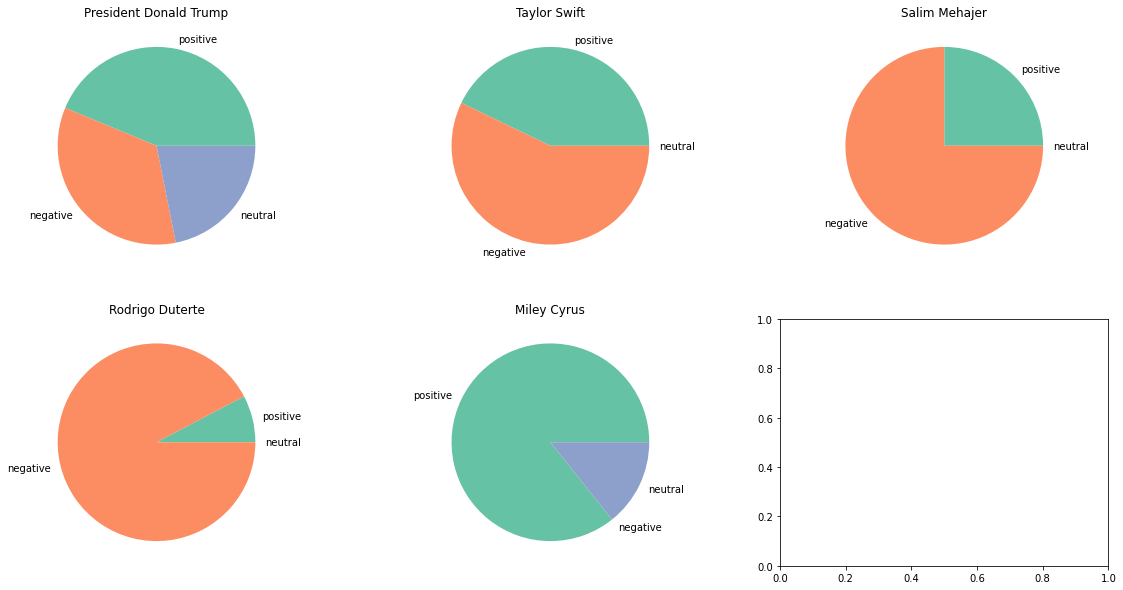

In [ ]:
names_to_plot = ["President Donald Trump", "Taylor Swift", "Salim Mehajer", "Rodrigo Duterte", "Miley Cyrus"]
sentiment, mean_sentiment = sentiment_analysis_speaker(speaker_name = names_to_plot, plot = True)

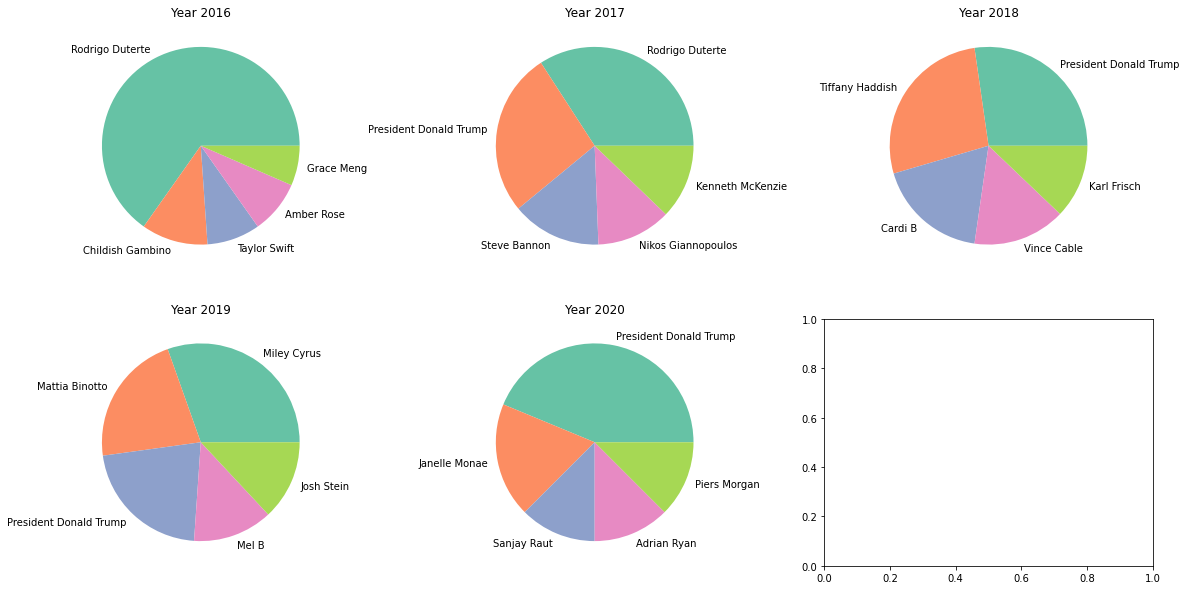

In [ ]:
speakers = speakers_with_max_hate_quotes(method = "MAX", N = 5, verbose = False, plot = True)

### 1.4 Terrorism activism

In [33]:
path_csis_folder = "/content/drive/Shareddrives/Ada-The data collectivists/data/CSIS/"
terrorism_filename = "csis_wapo_domestic_terrorism.csv"
df_terrorism = pd.read_csv(path_csis_folder + terrorism_filename)

# Only between 2016 and July 2020
df_terrorism = df_terrorism.query("Year_csis >= 2016 and Year_csis <= 2020")
df_terrorism[df_terrorism['Year_csis'] == 2020] = df_terrorism.query(
                        'Year_csis == 2020 and Month_csis <= 3')

# Getting rid of invalid values
df_terrorism = df_terrorism[df_terrorism['Day_csis'] != 0]
df_terrorism['Month_csis'].value_counts(dropna=False)
cols=["Year_csis","Month_csis","Day_csis"]
df_terrorism.dropna(subset = cols, inplace = True)



df_terrorism["Year_csis"] = df_terrorism["Year_csis"].astype(int)
df_terrorism["Month_csis"] = df_terrorism["Month_csis"].astype(int)
df_terrorism["Day_csis"] = df_terrorism["Day_csis"].astype(int)

df_terrorism['date'] = df_terrorism[cols].apply(lambda x: '-'.join(
                            x.values.astype(str)), axis="columns")
	
df_terrorism['date']=pd.to_datetime(df_terrorism['date'])


df_terrorism

,Year_csis,Month_csis,Day_csis,State_csis,City_csis,Orientation_csis,vict_killed_csis,LE_status_csis,MIL_status_csis,Target_csis,Weapon_csis,Lat_csis,Long_csis,type_extremism_1,type_extremism_2,victim_category,victim_specific1,victim_specific2,susp_total,susp_hometown,susp_social_media_use,date
20,2020,3,19,New Mexico,Kirtland Air Force Base,Violent Far-right,0.0,NaN,Active,Unknown,Firearms,35.054000,-106.533900,other,NaN,NaN,NaN,NaN,1.0,"Albuquerque, NM",NaN,2020-03-19
32,2020,2,25,Washington,Seattle,Violent Far-right,0.0,NaN,NaN,Journalists and Media,Other,47.606200,-122.332000,white supremacist,NaN,group,jewish,media,4.0,"Redmond, WA - Montgomery, TX - Spring Hill, FL...",various,2020-02-25
42,2020,1,14,Delaware,Newark,Violent Far-right,0.0,NaN,Veteran,Demonstrators,Firearms,39.683700,-75.749700,NaN,NaN,group,black,jewish,3.0,"Newark, DE - Denton, MD",encrypted chats,2020-01-14
43,2020,1,15,Georgia,Silver Creek,Violent Far-right,0.0,NaN,NaN,Demonstrators,Firearms,34.175300,-85.160900,white supremacist,NaN,demonstration,social justice,NaN,3.0,"Dalton, GA - Dacula, GA - Silver Creek, GA",encrypted chats,2020-01-15
44,2020,3,24,Missouri,Belton,Violent Far-right,0.0,NaN,Veteran,Other,Explosives and Incendiaries,38.815797,-94.535556,white supremacist,anti covid lockdown,building,jewish,black,1.0,"Belton, MO",encrypted chats,2020-03-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,2016,10,27,Alabama,NaN,Violent Far-right,0.0,NaN,NaN,"Government, Military, and Police",NaN,31.402627,-85.988207,anti government,conspiracy theorist,building,education,NaN,NaN,"Douglas, Ga.",NaN,2016-10-27
359,2016,10,30,California,Ronaldo,Violent Far-right,0.0,NaN,NaN,Private Individuals,Melee,32.715300,-117.157000,anti muslim,NaN,individual,muslim,NaN,3.0,"San Diego, CA",NaN,2016-10-30
360,2016,11,10,Pennsylvania,Philadelphia,Violent Far-right,0.0,NaN,NaN,Private Individuals,Melee,40.038200,-75.344600,white supremacist,NaN,individual,black,NaN,NaN,NaN,NaN,2016-11-10
361,2016,11,23,New Mexico,Albuquerque,Violent Far-right,0.0,NaN,NaN,Business,Explosives and Incendiaries,35.091952,-106.586558,other,NaN,building,NaN,NaN,NaN,NaN,NaN,2016-11-23


In [25]:
print("Orientation of attacks:\n", df_terrorism['Orientation_csis'].value_counts(dropna = False))
print("\n\nMotivations:\n", df_terrorism['type_extremism_1'].value_counts(dropna = False))

Orientation of attacks:
 Violent Far-right    179
Religious             54
Violent Far-left      42
Other                  5
Ethnonationalist       2
Name: Orientation_csis, dtype: int64


Motivations:
 NaN                    105
white supremacist       54
anti muslim             26
anti semitic            18
anti government         15
racist                  12
anti blm                12
anti immigrant           8
anti abortion            7
other                    6
anti lgbtq               6
incel                    4
anti covid lockdown      2
anti police              2
conspiracy theorist      2
anti asian               2
anti left                1
Name: type_extremism_1, dtype: int64


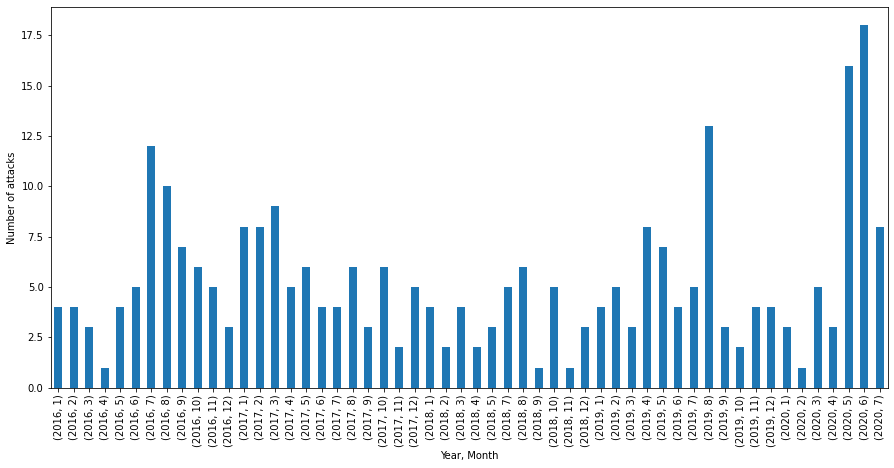

In [34]:
df_terrorism["date"] = (df_terrorism["date"].astype("datetime64"))

df_terrorism_far_right = df_terrorism.query("Orientation_csis == 'Violent Far-right'")
df_terrorism_far_left = df_terrorism.query("Orientation_csis == 'Violent Far-left'")

month_groups_terrorism = df_terrorism.groupby([df_terrorism['Year_csis'],df_terrorism['Month_csis']]
                          ).size()

month_groups.plot(kind='bar',figsize=(15,7),legend=None)
plt.xlabel("Year, Month")
plt.ylabel("Number of attacks")
plt.show()

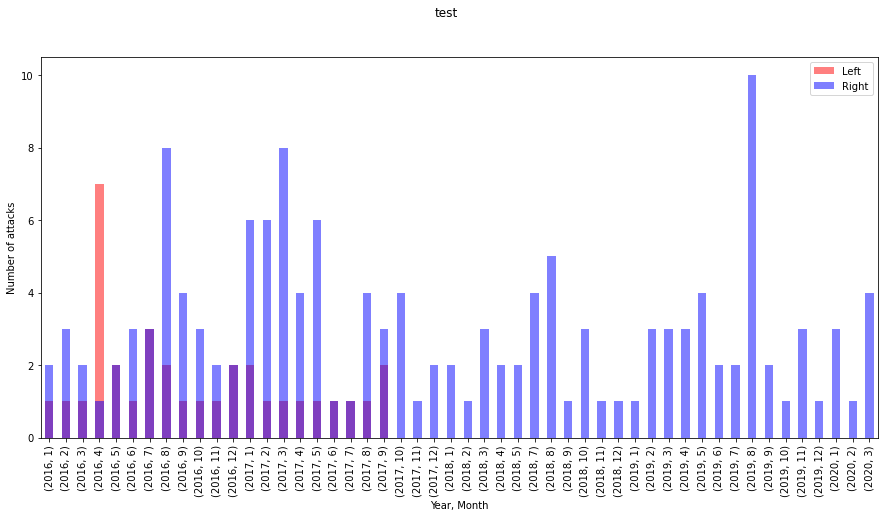

In [35]:
month_groups_left = df_terrorism_far_left.groupby([df_terrorism_far_left['Year_csis'],
                          df_terrorism_far_left['Month_csis']]).size()

df_terrorism_far_right = df_terrorism.query("Orientation_csis == 'Violent Far-right'")
month_groups_right = df_terrorism_far_right.groupby([df_terrorism_far_right['Year_csis'],
                          df_terrorism_far_right['Month_csis']]).size()

month_groups_left.plot(kind='bar',figsize=(15,7),label='Left', color = 'r', alpha = 0.5)
month_groups_right.plot(kind='bar',figsize=(15,7),label='Right', color = 'b', alpha = 0.5)



#month_groups_right.plot(kind='bar',figsize=(15,7),legend=None)
#plt.hist([month_groups_right, month_groups_left], label = ['Far-right violence', 'Far-left violence'])
plt.legend()
plt.suptitle("test")
plt.xlabel("Year, Month")
plt.ylabel("Number of attacks")
plt.show()

### 1.5 Study of correlation between hate speech in the media and violent attacks in the US

In [28]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
path = '/content/drive/Shareddrives/Ada-The data collectivists/data/'
path_SF = path + 'df_SF/'

df = pd.read_csv(path_SF + 'df_SF.csv')

Before analyzing any correlation between the quotes appearances and the timeline of violent events, let's visualize the sentiment of the selected quotes with VaderSentiment

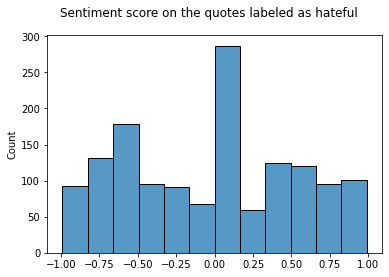

628

In [29]:
#Sentiment analysis

import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
df_sentiment = df.copy()
df_sentiment['compound_sentiment'] = df_sentiment['quotation'].map(lambda x: analyzer.polarity_scores(x)['compound'])
df['compound_sentiment'] = df['quotation'].map(lambda x: analyzer.polarity_scores(x)['compound'])

scores = df_sentiment['compound_sentiment'].to_numpy()
sns.histplot(data = scores)
plt.suptitle("Sentiment score on the quotes labeled as hateful")
plt.show()
df = df.query("compound_sentiment < -0.1")
len(df)

In [38]:

df_terrorism_far_right = df_terrorism.query("Orientation_csis == 'Violent Far-right'")
month_groups_terrorism = df_terrorism_far_right.groupby([df_terrorism_far_right['Year_csis'],
                          df_terrorism_far_right['Month_csis']]).size()


df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month

hate_count = pd.DataFrame(df.groupby([df['year'],df['month']]).size()).reset_index()
hate_count.columns = ['year', 'month', 'count']


# Adding zeros to month where zero hate quotes have been labeled
def add_zeros(df):
  out = df.copy()
  out.columns = ['year', 'month', 'count']
  months = np.arange(1,13)
  years = np.arange(2016,2020)
  for year in years:
    for month in months:
      if len(out.query("year == @year and month == @month")) == 0:
        row = {'year':year, 'month':month,'count':0}
        out = out.append(row, ignore_index = True)


  out = out.sort_values(by = ['year', 'month'])
  return out


df_terro = pd.DataFrame(month_groups_terrorism).reset_index()
df_terro = df_terro.iloc[:, -3:]
df_terro = add_zeros(df_terro)
df_hate = add_zeros(hate_count)


pcorr, _ = pearsonr(df_terro['count'], df_hate['count'])
scorr, _ = spearmanr(df_terro['count'], df_hate['count'])
print('The pearson correlation yields : ', pcorr)
print('The spearman correlation yields : ', scorr)

The pearson correlation yields :  -0.001988348016584873
The spearman correlation yields :  0.01922312758823093


Text(0.5, 0.98, 'Domestic far-right terrorist attacks on US soil, ')

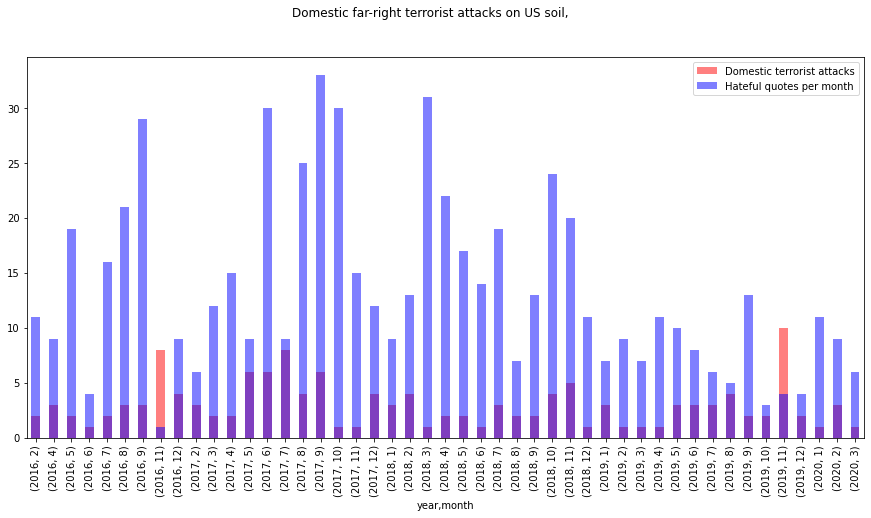

In [37]:

df_terrorism_far_right = df_terrorism.query("Orientation_csis == 'Violent Far-right'")
month_groups_right = df_terrorism_far_right.groupby([df_terrorism_far_right['Year_csis'],
                          df_terrorism_far_right['Month_csis']]).size()


month_groups_terrorism = df_terrorism_far_right.groupby([df_terrorism_far_right['Year_csis'],
                          df_terrorism_far_right['Month_csis']]).size()

month_groups_hate = df.groupby([df['year'],
                          df['month']]).size()

month_groups_right.plot(kind='bar',figsize=(15,7),label='Domestic terrorist attacks', color = 'r', alpha = 0.5)
month_groups_hate.plot(kind='bar',figsize=(15,7),label='Hateful quotes per month', color = 'b', alpha = 0.5)
plt.legend()
plt.suptitle('Domestic far-right terrorist attacks on US soil, ')